In [ ]:
# Folder Containing PDF Files

folder_path = "/content/drive/MyDrive/ScaleDux_Task"

In [2]:
# Installing BAsic Libraries
!pip install pymupdf pandas textblob spacy matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 51.3 MB/s eta 0:00:00


In [ ]:
# Extracting & Preprocessing Text

import fitz  # PyMuPDF
import os
import re

def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text() + "\n"
    return text

def preprocess_text(raw_text):
    cleaned = re.sub(r'\n+', '\n', raw_text)
    slides = cleaned.split('\n\n')
    return [slide.strip() for slide in slides if slide.strip()]


In [ ]:
# Keywords Sectioning

SECTION_KEYWORDS = {
    'Problem': ['problem', 'pain point', 'challenge'],
    'Solution': ['solution', 'how we solve'],
    'Market': ['market size', 'TAM', 'opportunity'],
    'Traction': ['users', 'growth', 'metrics', 'MoM'],
    'Business Model': ['business model', 'revenue', 'subscription'],
    'Team': ['team', 'founder', 'background'],
    'Ask': ['ask', 'funding', 'raise']
}

def categorize_slides(slides):
    categories = {key: [] for key in SECTION_KEYWORDS}
    categories['Other'] = []

    for slide in slides:
        matched = False
        lower = slide.lower()
        for category, keywords in SECTION_KEYWORDS.items():
            if any(kw in lower for kw in keywords):
                categories[category].append(slide)
                matched = True
                break
        if not matched:
            categories['Other'].append(slide)
    return categories


In [ ]:
# Scoring Keywords

from textblob import TextBlob
import spacy
nlp = spacy.load("en_core_web_sm")

SCORE_KEYWORDS = {
    'Problem Clarity': ['problem', 'pain', 'need'],
    'Market Potential': ['billion', 'TAM', 'market', 'growth'],
    'Traction Strength': ['growth', 'metrics', 'users', 'downloads'],
    'Team Experience': ['founder', 'mba', 'phd', 'experience'],
    'Business Model': ['subscription', 'SaaS', 'transaction'],
    'Vision / Moat': ['moat', 'IP', 'advantage', 'unique']
}

def score_section(text, keywords):
    score = 0
    lower = text.lower()
    score += sum(1 for kw in keywords if kw in lower)
    score += 1 if TextBlob(text).sentiment.polarity > 0.3 else 0
    return min(score, 10)

def score_deck(categorized):
    scores = {}
    for dimension, keywords in SCORE_KEYWORDS.items():
        score = 0
        for section in categorized.values():
            for slide in section:
                score += score_section(slide, keywords)
        scores[dimension] = min(score, 10)
    scores["Total"] = sum(scores.values())
    scores["Normalized Score"] = round(scores["Total"] / 60 * 100, 2)
    return scores


In [ ]:
# Processing All PDF From the Folder

import pandas as pd

def get_all_pdfs(folder_path):
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".pdf")]

results = {}
scores = {}

for pdf_file in get_all_pdfs("/content/drive/MyDrive/ScaleDux_Task"):
    raw = extract_text_from_pdf(pdf_file)
    slides = preprocess_text(raw)
    categorized = categorize_slides(slides)
    results[os.path.basename(pdf_file)] = categorized
    scores[os.path.basename(pdf_file)] = score_deck(categorized)


In [ ]:
# Saving the Pitch Scores

score_df = pd.DataFrame.from_dict(scores, orient='index')
score_df.reset_index(inplace=True)
score_df.rename(columns={"index": "Deck Name"}, inplace=True)
score_df.to_csv("pitch_scores.csv", index=False)


/tmp/ipython-input-9-2779491742.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=score_df.sort_values("Normalized Score", ascending=False),


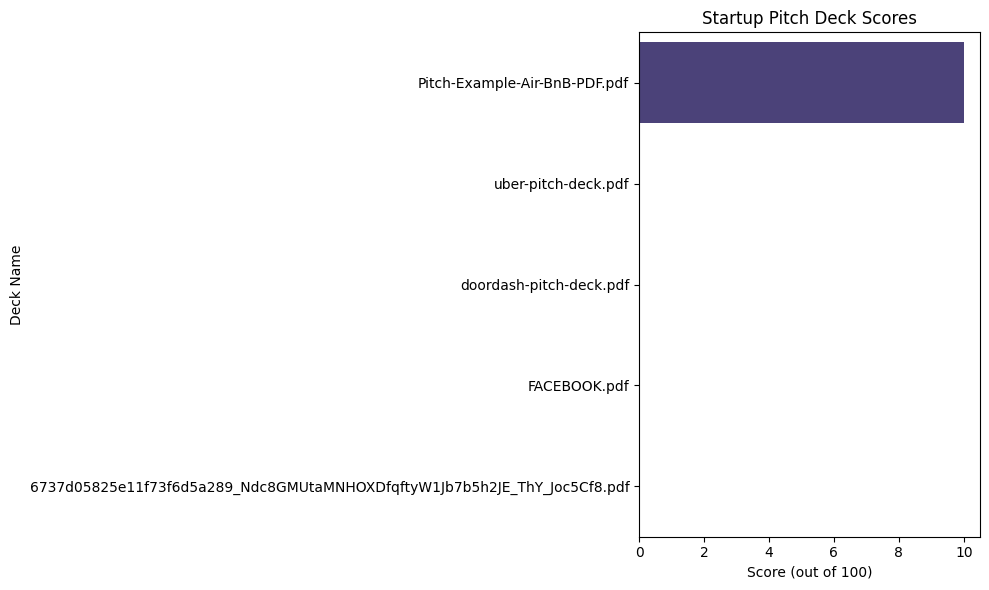

In [ ]:
# Visualizing

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=score_df.sort_values("Normalized Score", ascending=False),
            x="Normalized Score", y="Deck Name", palette="viridis")
plt.title("Startup Pitch Deck Scores")
plt.xlabel("Score (out of 100)")
plt.tight_layout()
plt.show()


In [ ]:
# Reading the Pitch Scores from csv

df = pd.read_csv("pitch_scores.csv")

In [ ]:
df

(<module 'pandas' from '/usr/local/lib/python3.11/dist-packages/pandas/__init__.py'>,
                                            Deck Name  Problem Clarity  \
 0                      Pitch-Example-Air-BnB-PDF.pdf                1   
 1                                uber-pitch-deck.pdf                0   
 2                            doordash-pitch-deck.pdf                0   
 3                                       FACEBOOK.pdf                0   
 4  6737d05825e11f73f6d5a289_Ndc8GMUtaMNHOXDfqftyW...                0   
 
    Market Potential  Traction Strength  Team Experience  Business Model  \
 0                 2                  1                0               1   
 1                 0                  0                0               0   
 2                 0                  0                0               0   
 3                 0                  0                0               0   
 4                 0                  0                0               0   
 
    Vision